# Appropriate Location for Italian Restaurant in Toronto

### Libraries

In [ ]:
import numpy as np
import pandas as pd
import requests
from bs4 import BeautifulSoup
from tabulate import tabulate
import requests
from pandas.io.json import json_normalize
import matplotlib.cm as cm
import matplotlib.colors as colors

from sklearn.cluster import KMeans

# !conda install -c conda-forge folium=0.5.0 --yes
import folium

# !conda install -c conda-forge geocoder --yes
import geocoder

# !conda install -c conda-forge geopy --yes
from geopy.geocoders import Nominatim

## Data Collecting& Analyzing & Understanding & Cleaning & Generating

## Sources : Wikipedia & Geo Codes & Foursquare API

## P.S. : Basic Neighborhood Clustering Analysis

### Scraping into Dataframe

In [ ]:
res = requests.get("https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M")
soup = BeautifulSoup(res.content,'html')
table = soup.find_all('table')[0] 
df_ = pd.read_html(str(table))
df = df_[0]

In [ ]:
df.rename({"Postcode": "PostalCode"}, axis=1, inplace=True)

In [ ]:
df.head()

### Excluding the "Not Assigned" Borough

In [ ]:
df = df[df["Borough"] != "Not assigned"]

In [ ]:
df.head()

### Updating Neighborhood with Borough if Neighborhood is "Not Assigned"

In [ ]:
df[df["Neighbourhood"] == "Not assigned"]

In [ ]:
df["Neighbourhood"] = np.where(df["Neighbourhood"] == "Not assigned", df["Borough"], df["Neighbourhood"])

In [ ]:
df.head()

In [ ]:
df[df["Borough"] == "Queen's Park"]

### Maybe, two rows will be combined into one row with the neighborhoods separated with a comma

In [ ]:
df_agg = df.groupby(["PostalCode", "Borough"]).agg({'Neighbourhood': lambda x: ', '.join(x)}).reset_index()

In [ ]:
df_agg.head()

In [ ]:
df[df["PostalCode"] == "M5B"]

In [ ]:
df_agg[df_agg["PostalCode"] == "M5B"]

### Shape of Dataframe

In [ ]:
df_agg.shape

### Geo Spatial Data

In [ ]:
df_geo = pd.read_csv("http://cocl.us/Geospatial_data")

In [ ]:
df_geo.head()

In [ ]:
df_geo.rename({"Postal Code": "PostalCode"}, axis=1, inplace=True)

In [ ]:
df_agg_geo = pd.merge(df_agg,
                      df_geo,
                      on="PostalCode",
                      how="left")

In [ ]:
df_agg_geo.head()

### Clustering Analysis for Only Neighborhoods

In [ ]:
address = 'Toronto, Canada'
geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of the City of Toronto are {}, {}.'.format(latitude, longitude))

In [ ]:
df_toronto = df_agg_geo[df_agg_geo['Borough'].str.contains('Toronto')].reset_index(drop=True)

In [ ]:
toronto_map = folium.Map(location=[latitude, longitude], zoom_start=12)

X = df_toronto['Latitude']
Y = df_toronto['Longitude']
Z = np.stack((X, Y), axis=1)

kmeans = KMeans(n_clusters=4, random_state=0).fit(Z)

clusters = kmeans.labels_
colors = ['red', 'green', 'blue', 'yellow']
df_toronto['Cluster'] = clusters

for latitude, longitude, borough, cluster in zip(df_toronto['Latitude'], 
                                                 df_toronto['Longitude'], 
                                                 df_toronto['Borough'], 
                                                 df_toronto['Cluster']):
    label = folium.Popup(borough, parse_html=True)
    folium.CircleMarker(
        [latitude, longitude],
        radius=5,
        popup=label,
        color='black',
        fill=True,
        fill_color=colors[cluster],
        fill_opacity=0.7).add_to(toronto_map)  

toronto_map

### Foursquare API with Developer Account

In [ ]:
df_toronto.head()

In [ ]:
CLIENT_ID = '' # your Foursquare ID
CLIENT_SECRET = '' # your Foursquare Secret
VERSION = '' # Foursquare API version
LIMIT = 100 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])
   
    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
toronto_venues = getNearbyVenues(names=df_toronto['Neighbourhood'],
                                latitudes=df_toronto['Latitude'],
                                longitudes=df_toronto['Longitude'])

### Data for Italian Restaurants

In [ ]:
"Italian Restaurant" in toronto_venues['Venue Category'].unique()

In [ ]:
to_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
to_onehot['Neighborhoods'] = toronto_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [to_onehot.columns[-1]] + list(to_onehot.columns[:-1])
to_onehot = to_onehot[fixed_columns]

print(to_onehot.shape)
to_onehot.head()

In [ ]:
to_grouped = to_onehot.groupby(["Neighborhoods"]).mean().reset_index()

print(to_grouped.shape)
to_grouped

In [ ]:
len(to_grouped[to_grouped["Italian Restaurant"] > 0])

### Master Table for Model

In [ ]:
to_italian = to_grouped[["Neighborhoods","Italian Restaurant"]]

In [ ]:
to_italian.head()

## KMeans Clustering Model for Italian Restaurant Locations

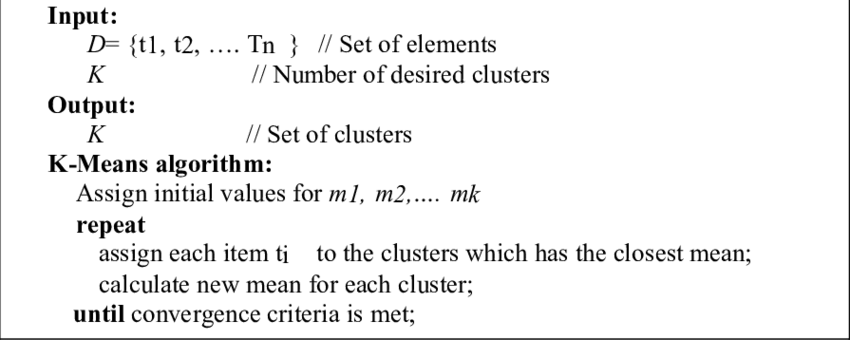

In [ ]:
toclusters = 3

to_clustering = to_italian.drop(["Neighborhoods"], 1)

# run k-means clustering
kmeans = KMeans(n_clusters=toclusters, random_state=1)
kmeans.fit_transform(to_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:20]

In [ ]:
to_merged = to_italian.copy()

# add clustering labels
to_merged["Cluster Labels"] = kmeans.labels_

In [ ]:
to_merged.rename(columns={"Neighborhoods": "Neighborhood"}, inplace=True)
to_merged.head(5)

In [ ]:
to_merged = to_merged.join(toronto_venues.set_index("Neighborhood"), on="Neighborhood")

print(to_merged.shape)
to_merged.head()

In [ ]:
to_merged.sort_values(["Cluster Labels"], inplace=True)
to_merged.head()

### Visualizing the Model Predicted Clusters

In [ ]:
lat_toronto = df_toronto['Latitude'].mean()
lon_toronto = df_toronto['Longitude'].mean()

In [ ]:
map_clusters = folium.Map(location=[lat_toronto, lon_toronto],zoom_start=14)

# set color scheme for the clusters


# add markers to the map
markers_colors={}
markers_colors[0] = 'red'
markers_colors[1] = 'blue'
markers_colors[2] = 'green'
markers_colors[3] = 'yellow'
markers_colors[4] = 'cyan'
markers_colors[5] = 'black'
for lat, lon, cluster in zip(to_merged['Neighborhood Latitude'], to_merged['Neighborhood Longitude'], to_merged['Cluster Labels']):
    
    
    folium.features.CircleMarker(
        [lat, lon],
        radius=5,
       
        color =markers_colors[cluster],
        fill_color=markers_colors[cluster],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

### Analysis of Model Predicted Clusters

In [ ]:
#Cluster 0
to_merged.loc[(to_merged['Cluster Labels'] ==0) & (to_merged['Venue Category'] == 'Italian Restaurant') ]["Neighborhood"].count()

In [ ]:
#Cluster 1
to_merged.loc[(to_merged['Cluster Labels'] ==1) & (to_merged['Venue Category'] == 'Italian Restaurant') ]["Neighborhood"].count()

In [ ]:
#Cluster 2
to_merged.loc[(to_merged['Cluster Labels'] ==2) & (to_merged['Venue Category'] == 'Italian Restaurant') ]["Neighborhood"].count()

## Result

* Most of the Indian restaurants are in cluster 1.
* Lowest in Cluster 0 which are in North Toronto. Also, there are good opportunities to open.
* Looking at nearby venues it seems cluster 2 might be a good location as there are not a lot of Italian restaurants in these areas. 
* Therefore, this project recommends the entrepreneur to open an Italian restaurant in these locations.